# Recommender Systems Challenge, 2023/2024 @ PoliMi

# Introduction

## Problem Description
The application domain is book recommendation. The datasets contain interactions of users with books, in particular, if the user attributed to the book a rating of at least 4. The main goal of the competition is to discover which items (books) a user will interact with.

The datasets includes around 600k interactions, 13k users, 22k items (books).
The training-test split is done via random holdout, 80% training, 20% test.
The goal is to recommend a list of 10 potentially relevant items for each user.


## Datasets
All files are comma-separated (columns are separated with ',' ).

- **data_train.csv**:
Contains the training set, describing implicit preferences expressed by the users.
    - **user_id** : identifier of the user
    - **item_id** : identifier of the item (Book)
    - **data** : "1.0" if the user liked the book attributing it a rating of at least 4.


- **data_target_users_test.csv**:
Contains the ids of the users that should appear in your submission file.
The submission file should contain all and only these users.

- **sample_submission.csv**:
A sample submission file in the correct format: [user_id],[ordered list of recommended items].
Be careful with the spaces and be sure to recommend the correct number of items to every user.

# Requirements

The working environment and the required libraries are defined here.

In [1]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps # creation of sparse matrix
import matplotlib.pyplot as pyplot # plot

from tqdm import tqdm

from scipy.stats import uniform, loguniform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import optuna as op

In [2]:
%load_ext Cython

# Data Preprocessing

In [3]:
# Handle the input file
input_file = open('Input/data_train.csv', 'r')
type(input_file)

_io.TextIOWrapper

In [4]:
# Build the dataframe from the input file
input_df = pd.read_csv(
    filepath_or_buffer=input_file,
    dtype={0:int, 1:int, 2:int},
    names=['user_id','item_id','data'],
    header=0
)

input_df.shape

(478730, 3)

In [5]:
# Show the first rows of the dataframe
input_df

,user_id,item_id,data
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
...,...,...,...
478725,13024,13605,1
478726,13024,13823,1
478727,13024,15122,1
478728,13024,18185,1


In [6]:
# Build the COO matrix with the COO constructor: (data, (row, column))
URM_all = sps.coo_matrix(
    (input_df["data"].values,
    (input_df["user_id"].values, input_df["item_id"].values))
)

URM_all

<13025x22348 sparse matrix of type '<class 'numpy.int32'>'
	with 478730 stored elements in COOrdinate format>

In [7]:
# Convert the matrix to Compressed Sparse Row format
URM_all = URM_all.tocsr()

URM_all

<13025x22348 sparse matrix of type '<class 'numpy.intc'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [8]:
mapped_id, original_id = pd.factorize(input_df["user_id"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique UserID in the URM are {}".format(len(original_id)))

mapped_id, original_id = pd.factorize(input_df["item_id"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique ItemID in the URM are {}".format(len(original_id)))

input_df["user_id"] = input_df["user_id"].map(user_original_ID_to_index)
input_df["item_id"] = input_df["item_id"].map(item_original_ID_to_index)

Unique UserID in the URM are 12638
Unique ItemID in the URM are 22222


In [9]:
n_users = len(user_original_ID_to_index)
n_items = len(item_original_ID_to_index)

In [10]:
input_df

,user_id,item_id,data
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
478725,12637,617,1
478726,12637,7533,1
478727,12637,17034,1
478728,12637,18422,1


In [11]:
# Import Evaluators
from Evaluation.Evaluator import EvaluatorHoldout
from sklearn.model_selection import train_test_split
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [12]:
(user_ids_training_validation, user_ids_test,
 item_ids_training_validation, item_ids_test,
 ratings_training_validation, ratings_test) = train_test_split(input_df.user_id,
                                                    input_df.item_id,
                                                    input_df.data,
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=28)

In [15]:
training_val_df = pd.DataFrame(
    {'user_id': user_ids_training_validation,
    'item_id': item_ids_training_validation,
    'data': ratings_training_validation},
    columns=['user_id','item_id','data'],
)

In [16]:
training_val_df

,user_id,item_id,data
230965,6070,12396,1
80186,2125,9024,1
374408,9872,1950,1
216132,5690,124,1
70418,1873,2761,1
...,...,...,...
382964,10085,567,1
324886,8466,2427,1
353797,9298,3571,1
200697,5290,4505,1


In [19]:
training_val_df = training_val_df.reset_index(drop=True)

In [20]:
training_val_df

,user_id,item_id,data
0,6070,12396,1
1,2125,9024,1
2,9872,1950,1
3,5690,124,1
4,1873,2761,1
...,...,...,...
406915,10085,567,1
406916,8466,2427,1
406917,9298,3571,1
406918,5290,4505,1


In [21]:
# Set the number of folds to split
n_fold = 10

In [22]:
kf = KFold(n_splits=n_fold, shuffle=True, random_state=28)

In [23]:
for i, (_, v_ind) in enumerate(kf.split(training_val_df)):
    training_val_df.loc[training_val_df.index[v_ind], 'kfold'] = int(i)

In [24]:
training_val_df

,user_id,item_id,data,kfold
0,6070,12396,1,5.0
1,2125,9024,1,6.0
2,9872,1950,1,9.0
3,5690,124,1,2.0
4,1873,2761,1,9.0
...,...,...,...,...
406915,10085,567,1,6.0
406916,8466,2427,1,7.0
406917,9298,3571,1,5.0
406918,5290,4505,1,6.0


In [25]:
df_trains = []
df_vals = []

for i in range(n_fold):
    df_trains.append(training_val_df[training_val_df["kfold"]!=i])
    df_vals.append(training_val_df[training_val_df["kfold"]==i])
    
    df_trains[i] = df_trains[i].drop(columns=['kfold'])
    df_vals[i] = df_vals[i].drop(columns=['kfold'])

In [26]:
df_trains[0]

,user_id,item_id,data
0,6070,12396,1
1,2125,9024,1
2,9872,1950,1
3,5690,124,1
4,1873,2761,1
...,...,...,...
406915,10085,567,1
406916,8466,2427,1
406917,9298,3571,1
406918,5290,4505,1


In [27]:
df_vals[0]

,user_id,item_id,data
21,4185,1356,1
41,12582,1571,1
49,7155,12438,1
59,11180,2667,1
60,10504,587,1
...,...,...,...
406872,566,8252,1
406876,10986,1116,1
406879,7028,3620,1
406898,7328,5649,1


In [28]:
URM_trains = []
URM_validations = []


for i in range(n_fold):
    URM_trains.append(sps.coo_matrix(
    (df_trains[i]["data"].values,
    (df_trains[i]["user_id"].values, df_trains[i]["item_id"].values))
).tocsr())
    
    
    URM_validations.append(sps.coo_matrix(
    (df_vals[i]["data"].values,
    (df_vals[i]["user_id"].values, df_vals[i]["item_id"].values))
).tocsr())

In [29]:
URM_trains[0]

<12638x22222 sparse matrix of type '<class 'numpy.intc'>'
	with 366228 stored elements in Compressed Sparse Row format>

In [31]:
URM_train_validation = sps.csr_matrix((ratings_training_validation, (user_ids_training_validation, item_ids_training_validation)),
                           shape = (n_users, n_items))

URM_test = sps.csr_matrix((ratings_test, (user_ids_test, item_ids_test)),
                           shape = (n_users, n_items))

In [32]:
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_vals = []
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

for i in range(n_fold):
    evaluator_vals.append(EvaluatorHoldout(URM_validations[i], cutoff_list=[10]))

EvaluatorHoldout: Ignoring 2748 (21.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 4027 (31.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 4027 (31.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 4004 (31.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 3973 (31.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 4053 (32.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 3995 (31.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 4032 (31.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 4015 (31.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 3983 (31.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 4030 (31.9%) Users that have less than 1 test interactions


In [33]:
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender

In [34]:
slime_trains = []

for i in range(n_fold):
    slime = MultiThreadSLIM_SLIMElasticNetRecommender(URM_trains[i])
    slime.fit(topK=692, alpha=0.000722, l1_ratio=0.0702)
    slime_trains.append(slime)

SLIMElasticNetRecommender: URM Detected 262 ( 2.1%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 148 ( 0.7%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [03:17<00:00, 112.21it/s]


SLIMElasticNetRecommender: URM Detected 256 ( 2.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 139 ( 0.6%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [03:07<00:00, 118.33it/s]


SLIMElasticNetRecommender: URM Detected 261 ( 2.1%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 158 ( 0.7%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [03:20<00:00, 111.08it/s]


SLIMElasticNetRecommender: URM Detected 265 ( 2.1%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 148 ( 0.7%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22221 [03:09<00:00, 117.44it/s]


SLIMElasticNetRecommender: URM Detected 273 ( 2.2%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 147 ( 0.7%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [02:24<00:00, 153.28it/s]


SLIMElasticNetRecommender: URM Detected 254 ( 2.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 155 ( 0.7%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [02:45<00:00, 134.32it/s]


SLIMElasticNetRecommender: URM Detected 253 ( 2.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 145 ( 0.7%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [02:06<00:00, 175.58it/s]


SLIMElasticNetRecommender: URM Detected 249 ( 2.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 140 ( 0.6%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [02:07<00:00, 174.12it/s]


SLIMElasticNetRecommender: URM Detected 256 ( 2.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 151 ( 0.7%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [02:42<00:00, 136.59it/s]


SLIMElasticNetRecommender: URM Detected 248 ( 2.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 161 ( 0.7%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [02:42<00:00, 136.45it/s]


In [35]:
slime_train_val = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train_validation)
slime_train_val.fit(l1_ratio=0.0702, alpha=0.000722, topK=692)

SLIMElasticNetRecommender: URM Detected 149 ( 1.2%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 75 ( 0.3%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22216/22222 [02:09<00:00, 171.64it/s]


In [36]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.Similarity.Compute_Similarity import Compute_Similarity

In [37]:
itemhybrid_trains = []

for i in range(n_fold):
    sim1 = Compute_Similarity(URM_trains[i], shrink = 0, topK = 5, similarity = "cosine").compute_similarity()
    sim2 = Compute_Similarity(URM_trains[i], shrink = 0.5, topK = 65, similarity = "cosine").compute_similarity()

    itemhybrid = ItemKNNSimilarityHybridRecommender(URM_trains[i], sim1, sim2)
    itemhybrid.fit(topK = 70, alpha = 0.65)
    itemhybrid_trains.append(itemhybrid)

Similarity column 22222 (100.0%), 11866.48 column/sec. Elapsed time 1.87 sec
Similarity column 22222 (100.0%), 11742.03 column/sec. Elapsed time 1.89 sec
ItemKNNSimilarityHybridRecommender: URM Detected 262 ( 2.1%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 148 ( 0.7%) items with no interactions.
Similarity column 22222 (100.0%), 11849.94 column/sec. Elapsed time 1.88 sec
Similarity column 22222 (100.0%), 11907.49 column/sec. Elapsed time 1.87 sec
ItemKNNSimilarityHybridRecommender: URM Detected 256 ( 2.0%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 139 ( 0.6%) items with no interactions.
Similarity column 22222 (100.0%), 11884.80 column/sec. Elapsed time 1.87 sec
Similarity column 22222 (100.0%), 11875.17 column/sec. Elapsed time 1.87 sec
ItemKNNSimilarityHybridRecommender: URM Detected 261 ( 2.1%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 158 ( 0.7%) items with no interactions.
Simi

In [38]:
sim1_val = Compute_Similarity(URM_train_validation, shrink = 0, topK = 5, similarity = 'cosine').compute_similarity()
sim2_val = Compute_Similarity(URM_train_validation, shrink = 0.5, topK = 65, similarity = 'cosine').compute_similarity()
itemhybrid_train_val = ItemKNNSimilarityHybridRecommender(URM_train_validation, sim1_val, sim2_val)
itemhybrid_train_val.fit(topK = 70, alpha = 0.65)

Similarity column 22222 (100.0%), 11398.18 column/sec. Elapsed time 1.95 sec
Similarity column 22222 (100.0%), 11352.27 column/sec. Elapsed time 1.96 sec
ItemKNNSimilarityHybridRecommender: URM Detected 149 ( 1.2%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 75 ( 0.3%) items with no interactions.


In [39]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

In [40]:
rp3beta_trains = []

for i in range(n_fold):
    rp3beta = RP3betaRecommender(URM_trains[i])
    rp3beta.fit(topK=25, alpha=0.253519, beta=0.209538, implicit=True,
               normalize_similarity=True)
    rp3beta_trains.append(rp3beta)

RP3betaRecommender: URM Detected 262 ( 2.1%) users with no interactions.
RP3betaRecommender: URM Detected 148 ( 0.7%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6807.82 column/sec. Elapsed time 3.26 sec
RP3betaRecommender: URM Detected 256 ( 2.0%) users with no interactions.
RP3betaRecommender: URM Detected 139 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6784.18 column/sec. Elapsed time 3.28 sec
RP3betaRecommender: URM Detected 261 ( 2.1%) users with no interactions.
RP3betaRecommender: URM Detected 158 ( 0.7%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6748.53 column/sec. Elapsed time 3.29 sec
RP3betaRecommender: URM Detected 265 ( 2.1%) users with no interactions.
RP3betaRecommender: URM Detected 148 ( 0.7%) items with no interactions.
RP3betaRecommender: Similarity column 22221 (100.0%), 6885.37 column/sec. Elapsed time 3.23 sec
RP3betaRecommender: URM Detected

In [41]:
rp3beta_train_val = RP3betaRecommender(URM_train_validation)
rp3beta_train_val.fit(topK=25, alpha=0.253519, beta=0.209538, implicit=True, normalize_similarity=True)

RP3betaRecommender: URM Detected 149 ( 1.2%) users with no interactions.
RP3betaRecommender: URM Detected 75 ( 0.3%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6538.28 column/sec. Elapsed time 3.40 sec


In [42]:
from Recommenders.GeneralScoresHybridRecommender import GeneralScoresHybridRecommender

In [43]:
recommender_trains = []

for i in range(n_fold):
    general = GeneralScoresHybridRecommender(
        URM_trains[i], 
        [slime_trains[i], rp3beta_trains[i], itemhybrid_trains[i]])
    general.fit([0.7, 0.25, 0.05])
    
    recommender_trains.append(general)

GeneralScoresHybridRecommender: URM Detected 262 ( 2.1%) users with no interactions.
GeneralScoresHybridRecommender: URM Detected 148 ( 0.7%) items with no interactions.
GeneralScoresHybridRecommender: URM Detected 256 ( 2.0%) users with no interactions.
GeneralScoresHybridRecommender: URM Detected 139 ( 0.6%) items with no interactions.
GeneralScoresHybridRecommender: URM Detected 261 ( 2.1%) users with no interactions.
GeneralScoresHybridRecommender: URM Detected 158 ( 0.7%) items with no interactions.
GeneralScoresHybridRecommender: URM Detected 265 ( 2.1%) users with no interactions.
GeneralScoresHybridRecommender: URM Detected 148 ( 0.7%) items with no interactions.
GeneralScoresHybridRecommender: URM Detected 273 ( 2.2%) users with no interactions.
GeneralScoresHybridRecommender: URM Detected 147 ( 0.7%) items with no interactions.
GeneralScoresHybridRecommender: URM Detected 254 ( 2.0%) users with no interactions.
GeneralScoresHybridRecommender: URM Detected 155 ( 0.7%) items wi

In [44]:
recommender_train_val = GeneralScoresHybridRecommender(URM_train_validation, [slime_train_val, rp3beta_train_val, itemhybrid_train_val])
recommender_train_val.fit([0.7, 0.25, 0.05])

GeneralScoresHybridRecommender: URM Detected 149 ( 1.2%) users with no interactions.
GeneralScoresHybridRecommender: URM Detected 75 ( 0.3%) items with no interactions.


In [45]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

In [46]:
itemknncf_trains = []

for i in range(n_fold):
    itemknncf = ItemKNNCFRecommender(URM_trains[i])
    itemknncf.fit(shrink=15.47563, topK=12, similarity='dice')

    itemknncf_trains.append(itemknncf)

ItemKNNCFRecommender: URM Detected 262 ( 2.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 148 ( 0.7%) items with no interactions.
Similarity column 22222 (100.0%), 12194.39 column/sec. Elapsed time 1.82 sec
ItemKNNCFRecommender: URM Detected 256 ( 2.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 139 ( 0.6%) items with no interactions.
Similarity column 22222 (100.0%), 12157.01 column/sec. Elapsed time 1.83 sec
ItemKNNCFRecommender: URM Detected 261 ( 2.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 158 ( 0.7%) items with no interactions.
Similarity column 22222 (100.0%), 12209.75 column/sec. Elapsed time 1.82 sec
ItemKNNCFRecommender: URM Detected 265 ( 2.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 148 ( 0.7%) items with no interactions.
Similarity column 22221 (100.0%), 12220.73 column/sec. Elapsed time 1.82 sec
ItemKNNCFRecommender: URM Detected 273 ( 2.2%) users with no interactions.
ItemKNNCFRecommen

In [47]:
itemknncf_train_val = ItemKNNCFRecommender(URM_train_validation)
itemknncf_train_val.fit(shrink=15.47563, topK=12, similarity='dice')

ItemKNNCFRecommender: URM Detected 149 ( 1.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 75 ( 0.3%) items with no interactions.
Similarity column 22222 (100.0%), 11580.57 column/sec. Elapsed time 1.92 sec


In [48]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender

In [49]:
p3alpha_trains = []

for i in range(n_fold):
    p3alpha = P3alphaRecommender(URM_trains[i])
    p3alpha.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)
    p3alpha_trains.append(p3alpha)

P3alphaRecommender: URM Detected 262 ( 2.1%) users with no interactions.
P3alphaRecommender: URM Detected 148 ( 0.7%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 7025.10 column/sec. Elapsed time 3.16 sec
P3alphaRecommender: URM Detected 256 ( 2.0%) users with no interactions.
P3alphaRecommender: URM Detected 139 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 7062.97 column/sec. Elapsed time 3.15 sec
P3alphaRecommender: URM Detected 261 ( 2.1%) users with no interactions.
P3alphaRecommender: URM Detected 158 ( 0.7%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 7097.38 column/sec. Elapsed time 3.13 sec
P3alphaRecommender: URM Detected 265 ( 2.1%) users with no interactions.
P3alphaRecommender: URM Detected 148 ( 0.7%) items with no interactions.
P3alphaRecommender: Similarity column 22221 (100.0%), 7124.16 column/sec. Elapsed time 3.12 sec
P3alphaRecommender: URM Detected

In [50]:
p3alpha_train_val = P3alphaRecommender(URM_train_validation)
p3alpha_train_val.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)

P3alphaRecommender: URM Detected 149 ( 1.2%) users with no interactions.
P3alphaRecommender: URM Detected 75 ( 0.3%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 6704.87 column/sec. Elapsed time 3.31 sec


In [51]:
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender

In [52]:
ease_trains = []

for i in range(n_fold):
    ease = EASE_R_Recommender(URM_trains[i])
    ease.fit(topK=29, l2_norm=19)
    ease_trains.append(ease)

EASE_R_Recommender: URM Detected 262 ( 2.1%) users with no interactions.
EASE_R_Recommender: URM Detected 148 ( 0.7%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.50 min
EASE_R_Recommender: URM Detected 256 ( 2.0%) users with no interactions.
EASE_R_Recommender: URM Detected 139 ( 0.6%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.44 min
EASE_R_Recommender: URM Detected 261 ( 2.1%) users with no interactions.
EASE_R_Recommender: URM Detected 158 ( 0.7%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.48 min
EASE_R_Recommender: URM Detected 265 ( 2.1%) users with no interactions.
EASE_R_Recommender: URM Detected 148 ( 0.7%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.48 min
EASE_R_Recommender: URM Detected 273 ( 2.2%) use

In [53]:
ease_train_val = EASE_R_Recommender(URM_train_validation)
ease_train_val.fit(topK=29, l2_norm=19)

EASE_R_Recommender: URM Detected 149 ( 1.2%) users with no interactions.
EASE_R_Recommender: URM Detected 75 ( 0.3%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.41 min


In [55]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

In [56]:
userknncf_trains = []

for i in range(n_fold):
    userknncf = UserKNNCFRecommender(URM_trains[i])
    userknncf.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")
    userknncf_trains.append(userknncf)

UserKNNCFRecommender: URM Detected 262 ( 2.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 148 ( 0.7%) items with no interactions.
Similarity column 12638 (100.0%), 9531.90 column/sec. Elapsed time 1.33 sec
UserKNNCFRecommender: URM Detected 256 ( 2.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 139 ( 0.6%) items with no interactions.
Similarity column 12638 (100.0%), 11507.63 column/sec. Elapsed time 1.10 sec
UserKNNCFRecommender: URM Detected 261 ( 2.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 158 ( 0.7%) items with no interactions.
Similarity column 12638 (100.0%), 11496.41 column/sec. Elapsed time 1.10 sec
UserKNNCFRecommender: URM Detected 265 ( 2.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 148 ( 0.7%) items with no interactions.
Similarity column 12638 (100.0%), 11413.39 column/sec. Elapsed time 1.11 sec
UserKNNCFRecommender: URM Detected 273 ( 2.2%) users with no interactions.
UserKNNCFRecommend

In [57]:
userknncf_train_val = UserKNNCFRecommender(URM_train_validation)
userknncf_train_val.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")

UserKNNCFRecommender: URM Detected 149 ( 1.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 75 ( 0.3%) items with no interactions.
Similarity column 12638 (100.0%), 10603.29 column/sec. Elapsed time 1.19 sec


In [61]:
evaluator_test.evaluateRecommender(recommender_train_val)

EvaluatorHoldout: Processed 9890 (100.0%) in 7.23 sec. Users per second: 1368


(       PRECISION PRECISION_RECALL_MIN_DEN   RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                     
 10      0.082629                  0.16539  0.14844  0.041089    0.082192   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.247575  0.144129  0.106163  0.489181      0.315889  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.782561          0.382814    0.782561        0.08911   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.900592                   0.998882             0.254993   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                      

In [62]:
candidate_generator_recommenders = recommender_trains

In [71]:
training_dfs = []

for i in range(n_fold):
    n_users, n_items = URM_trains[i].shape
    training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["item_id"])
    training_dataframe.index.name='user_id'
    
    cutoff = 30

    for user_id in tqdm(range(n_users)):    
        recommendations = candidate_generator_recommenders[i].recommend(user_id, cutoff = cutoff)
        training_dataframe.loc[user_id, "item_id"] = recommendations
        
    training_dataframe = training_dataframe.explode("item_id")
    
    URM_validation_coo = sps.coo_matrix(URM_validations[i])

    correct_recommendations = pd.DataFrame({"user_id": URM_validation_coo.row,
                                        "item_id": URM_validation_coo.col})
    
    training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['user_id','item_id'], how='left', indicator='Exist')
    training_dataframe["Label"] = training_dataframe["Exist"] == "both"
    training_dataframe.drop(columns = ['Exist'], inplace=True)
    training_dfs.append(training_dataframe)

100%|██████████████████████████████████████████████████████████████████████████| 12638/12638 [00:09<00:00, 1307.69it/s]


In [72]:
other_algorithms = {
    "Hybrid": recommender_trains,
    "ItemKNNCF": itemknncf_trains,
    "P3alpha": p3alpha_trains,
    "RP3beta": rp3beta_trains,
    "SLIM-E": slime_trains,
    "EASE_R": ease_trains,
    "UserKNNCF": userknncf_trains,
    "ItemHybrid": itemhybrid_trains,
}

In [73]:
groups_all = []
y_trains = []
X_trains = []

for i in range(n_fold):
    training_dfs[i] = training_dfs[i].set_index('user_id')
    n_users, n_items = URM_trains[i].shape

    for user_id in tqdm(range(n_users)):  
        for rec_label, rec_instance in other_algorithms.items():
        
            item_list = training_dfs[i].loc[user_id, "item_id"].values.tolist()
        
            all_item_scores = rec_instance[i]._compute_item_score([user_id], items_to_compute = item_list)

            training_dfs[i].loc[user_id, rec_label] = all_item_scores[0, item_list] 

    training_dfs[i] = training_dfs[i].reset_index()
    training_dfs[i] = training_dfs[i].rename(columns = {"index": "user_id"})
    
    item_popularity = np.ediff1d(sps.csc_matrix(URM_trains[i]).indptr)
    training_dfs[i]['item_popularity'] = item_popularity[training_dfs[i]["item_id"].values.astype(int)]

    user_popularity = np.ediff1d(sps.csr_matrix(URM_trains[i]).indptr)
    training_dfs[i]['user_profile_len'] = user_popularity[training_dfs[i]["user_id"].values.astype(int)]

    training_dfs[i] = training_dfs[i].sort_values("user_id").reset_index()
    training_dfs[i].drop(columns = ['index'], inplace=True)

    groups = training_dfs[i].groupby("user_id").size().values
    groups_all.append(groups)
    
    y_train = training_dfs[i]["Label"]
    y_trains.append(y_train)
    
    X_train_xgb = training_dfs[i].drop(columns=["Label"])
    X_train_xgb["user_id"] = X_train_xgb["user_id"].astype("category")
    X_train_xgb["item_id"] = X_train_xgb["item_id"].astype("category")
    X_trains.append(X_train_xgb)

100%|███████████████████████████████████████████████████████████████████████████| 12638/12638 [00:46<00:00, 274.13it/s]


In [75]:
from xgboost import XGBRanker

In [90]:
n_estimators = 300
learning_rate = 0.2
reg_alpha = 30
reg_lambda = 0.1
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

colsample_bytree = 0.7
gamma = 5
min_child_weight = 5.0

XGB_models = []

for i in range(n_fold):
    XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )
    XGB_model.fit(X_trains[i],
          y_trains[i],
          group=groups_all[i],
          verbose=True)
    XGB_models.append(XGB_model)

In [91]:
%matplotlib inline
from xgboost import plot_importance

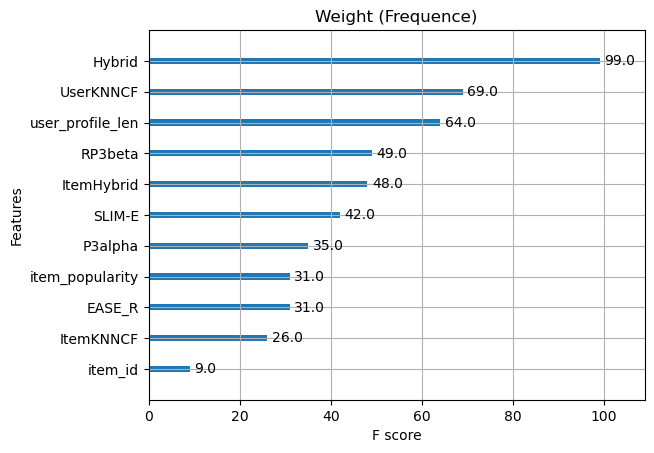

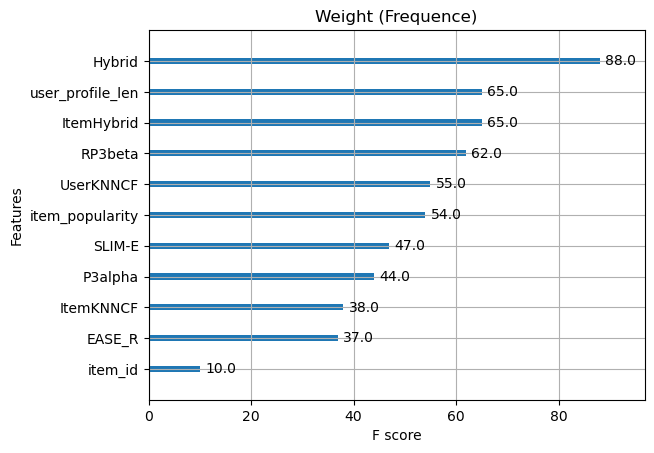

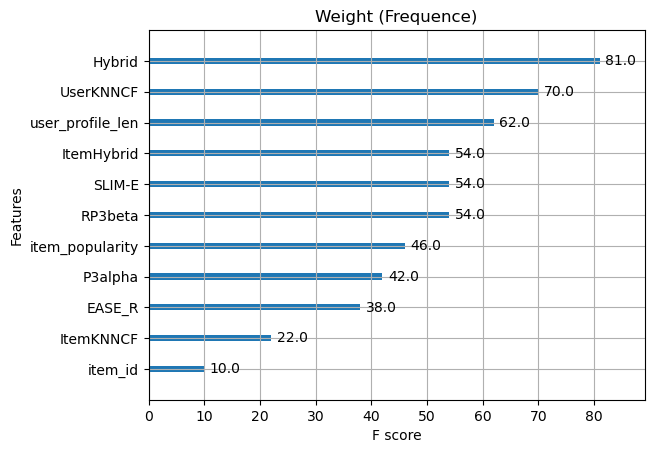

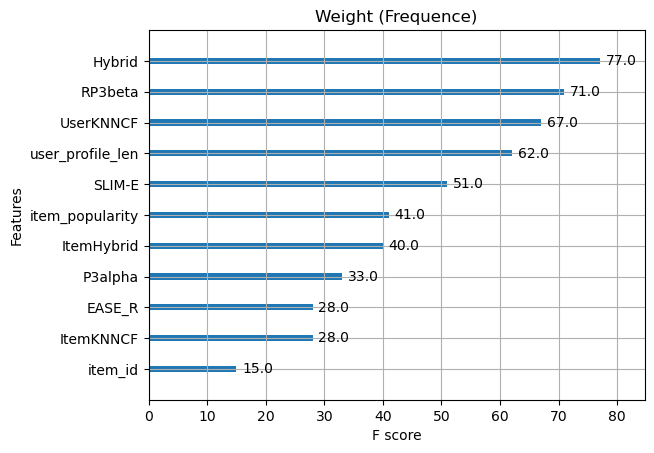

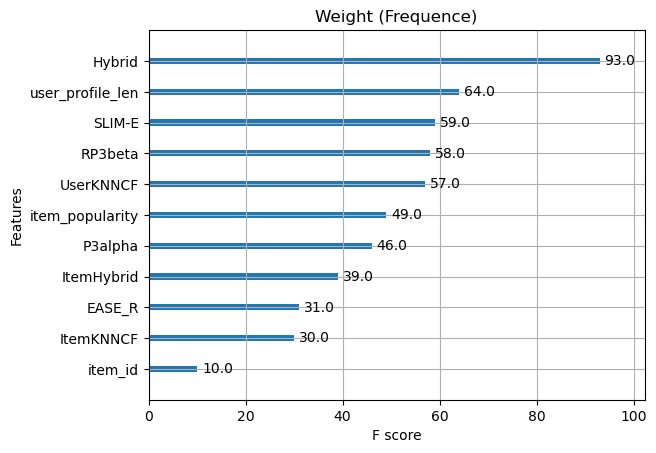

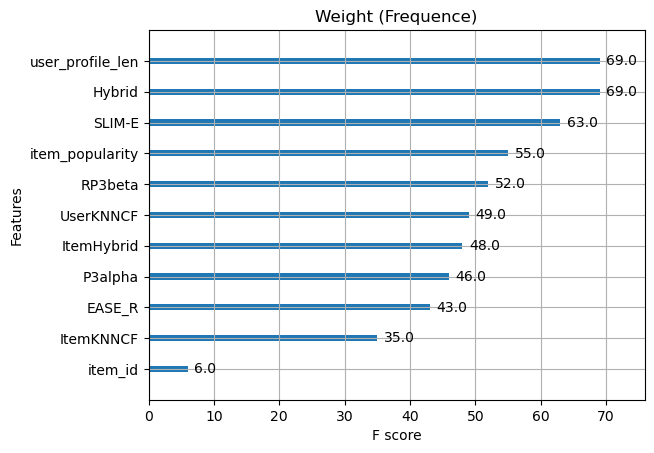

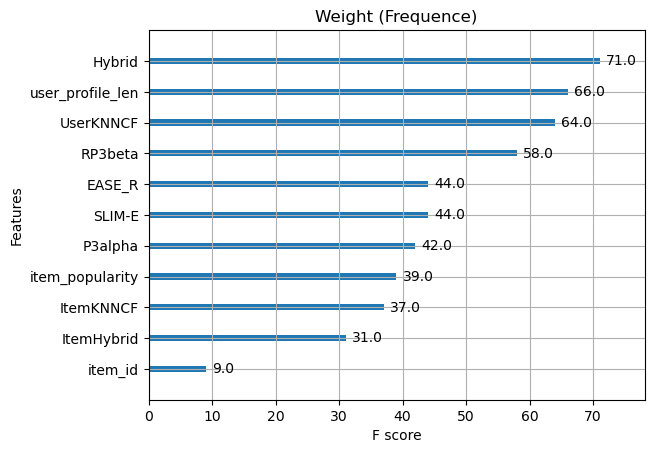

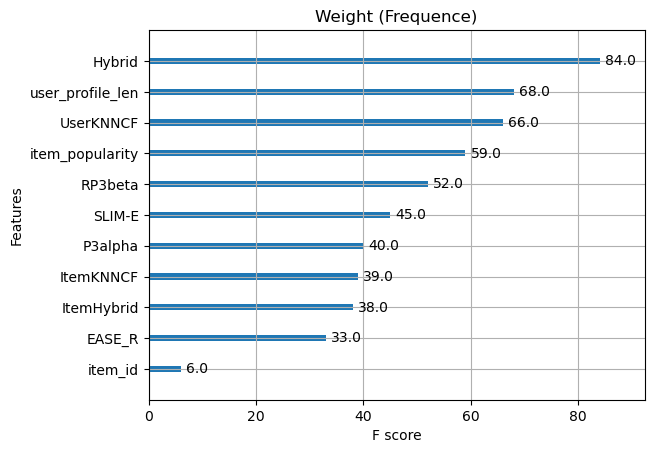

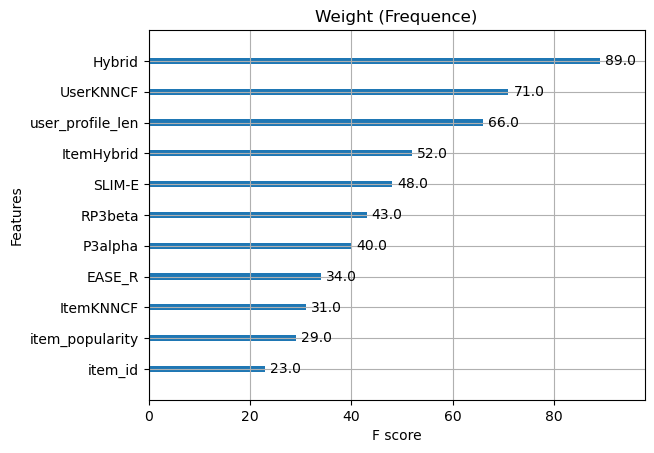

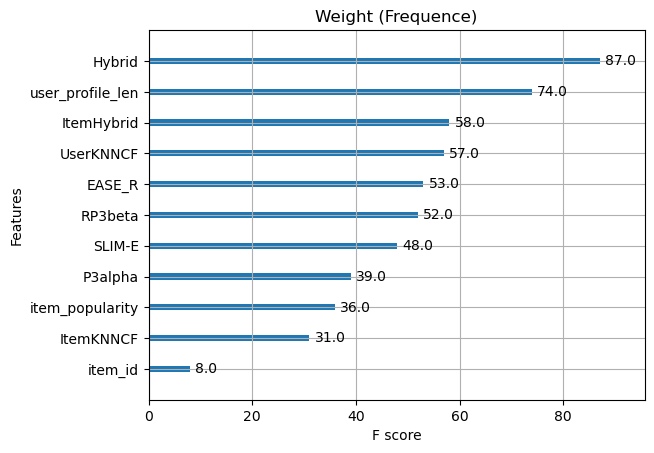

In [92]:
for i in range(n_fold):
    plot_importance(XGB_models[i], importance_type='weight', title='Weight (Frequence)')

## Build test dataframe

In [79]:
users_to_recommend = np.unique(URM_test.tocoo().row)

user_recommendations_items = []
user_recommendations_user_id = []

for id in tqdm(users_to_recommend):
    # getting the recommendations
    recommendations = recommender_train_val.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))
    
test_dataframe = pd.DataFrame({"user_id":user_recommendations_user_id, "item_id":user_recommendations_items})
test_dataframe

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:07<00:00, 1331.28it/s]


,user_id,item_id
0,0,674
1,0,587
2,0,1585
3,0,1449
4,0,2755
...,...,...
296695,12637,2744
296696,12637,696
296697,12637,694
296698,12637,10900


In [80]:
other_algorithms_train_validation = {
    "Hybrid": recommender_train_val,
    "ItemKNNCF": itemknncf_train_val,
    "P3alpha": p3alpha_train_val,
    "RP3beta": rp3beta_train_val,
    "SLIM-E": slime_train_val,
    "EASE_R": ease_train_val,
    "UserKNNCF": userknncf_train_val,
    "ItemHybrid": itemhybrid_train_val,
}

In [81]:
test_dataframe = test_dataframe.set_index('user_id')

for user_id in tqdm(users_to_recommend):       
    for rec_label, rec_instance in other_algorithms_train_validation.items():
        
        item_list = test_dataframe.loc[user_id, "item_id"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "user_id"})
test_dataframe

100%|█████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:37<00:00, 266.61it/s]


,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid
0,0,674,0.707126,0.476774,0.449333,0.665007,0.691153,0.490226,21.360912,1.141336
1,0,587,0.542200,0.364388,0.407392,0.585519,0.503543,0.479448,18.574888,0.866801
2,0,1585,0.352938,0.498560,0.078392,0.285449,0.345401,0.287270,8.803205,0.795905
3,0,1449,0.316864,0.320451,0.089741,0.212910,0.321710,0.223213,9.058813,0.768792
4,0,2755,0.263373,0.250000,0.093403,0.127471,0.291522,0.250040,5.904123,0.548794
...,...,...,...,...,...,...,...,...,...,...
296695,12637,2744,0.209180,0.219780,0.057413,0.085192,0.225546,0.153618,1.683679,0.599996
296696,12637,696,0.195657,0.288068,0.000000,0.000000,0.229636,0.100994,10.766883,0.698231
296697,12637,694,0.185977,0.217336,0.000000,0.091446,0.182399,0.060041,11.149442,0.708739
296698,12637,10900,0.185242,0.658782,0.131640,0.177300,0.090306,0.192275,5.961126,1.554053


In [82]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train_validation).indptr)
test_dataframe['item_popularity'] = item_popularity[test_dataframe["item_id"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)
test_dataframe['user_profile_len'] = user_popularity[test_dataframe["user_id"].values.astype(int)]

In [83]:
test_dataframe = test_dataframe.sort_values("user_id").reset_index()
test_dataframe.drop(columns = ['index'], inplace=True)
test_dataframe

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,674,0.707126,0.476774,0.449333,0.665007,0.691153,0.490226,21.360912,1.141336,377,39
1,0,6738,0.107051,0.254388,0.000000,0.038405,0.113020,0.155223,7.214179,0.366711,56,39
2,0,13840,0.108641,0.177604,0.021308,0.040576,0.120784,0.034449,2.142048,0.278974,21,39
3,0,3708,0.110808,0.151803,0.042367,0.059408,0.109396,0.129144,2.924329,0.387581,184,39
4,0,6184,0.112614,0.214719,0.022975,0.071083,0.104833,0.033368,1.733873,0.429200,28,39
...,...,...,...,...,...,...,...,...,...,...,...,...
296695,12637,9567,0.558235,0.891048,0.198555,0.357706,0.507333,0.358740,11.200864,2.273499,38,62
296696,12637,16591,0.579772,1.214878,0.306634,0.443415,0.443427,0.327396,5.272201,3.170400,11,62
296697,12637,10900,0.185242,0.658782,0.131640,0.177300,0.090306,0.192275,5.961126,1.554053,21,62
296698,12637,17033,0.354159,0.874667,0.131159,0.333195,0.211670,0.172596,2.464640,2.453839,5,62


In [84]:
def list_recommendations(target_users, recommender):
    recommendations_list = []
    
    for id in target_users:
        recommendations_per_user = recommender.recommend(user_id_array = id, remove_seen_flag=True, cutoff=10)
        recommendations_list.append(recommendations_per_user)
        
    return recommendations_list

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

# recommendations_list is the Python list of recommendations for each user in urm_test
def evaluate_recommender_MAP_from_rec_list(urm_test, recommendations_list, cutoff):
    target_users = np.unique(urm_test.tocoo().row)
    
    cumulative_AP = 0.0
    num_eval = 0
        
    for i in range(0, len(target_users)):
        relevant_items = urm_test.indices[urm_test.indptr[target_users[i]]:urm_test.indptr[target_users[i]+1]]
        
        if len(relevant_items)>0:
            recommended_items = recommendations_list[i]
            
            num_eval+=1
            
            cumulative_AP += AP(recommended_items, relevant_items)
            
    MAP = cumulative_AP / num_eval
    
    return MAP

## Predict!

In [85]:
user_recommendations = []

for user_id in tqdm(users_to_recommend):    
    user_recommendations.append(recommender_train_val.recommend(user_id, cutoff = 10))

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:07<00:00, 1349.78it/s]


In [95]:
recommendations_boosted_all = []
results = []

for f in range(n_fold):
    X = test_dataframe
    predictions = XGB_models[f].predict(X)

    xgb_reranked = test_dataframe.copy()
    xgb_reranked['rating_xgb'] = pd.Series(predictions, index=xgb_reranked.index)
    xgb_reranked = xgb_reranked.sort_values(['user_id','rating_xgb'], ascending=[True, False])

    user_recommendations_boosted = []

    for id in tqdm(users_to_recommend):
        user_recommendations_boosted.append(xgb_reranked.loc[xgb_reranked['user_id'] == id].item_id.values[:10].tolist())
        
    recommendations_boosted_all.append(user_recommendations_boosted)

    xgb_changed_item_count = 0

    for i in range(len(user_recommendations)):
        default_items = user_recommendations[i]
        xgb_reranked_items = user_recommendations_boosted[i]
    
        xgb_new_items = list(set(xgb_reranked_items) - set(default_items))
    
        xgb_changed_item_count = xgb_changed_item_count + len(xgb_new_items)

    n_users_to_recommend = len(users_to_recommend)
    n_recommended_items = n_users_to_recommend * 10

    print("XGBoost changed {} items, {:.2f}% of total".format(xgb_changed_item_count, xgb_changed_item_count/n_recommended_items * 100))

    print("Fold {}".format(f))
    print("Hybrid: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations, 10)))
    print("XGBoost: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)))
    
    results.append(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10))

100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3907.60it/s]


XGBoost changed 18676 items, 18.88% of total
Fold 0
Hybrid: 0.08219185888881989
XGBoost: 0.08275114435917771


100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3922.12it/s]


XGBoost changed 18905 items, 19.12% of total
Fold 1
Hybrid: 0.08219185888881989
XGBoost: 0.08300428717530524


100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3930.42it/s]


XGBoost changed 19132 items, 19.34% of total
Fold 2
Hybrid: 0.08219185888881989
XGBoost: 0.08311021389606653


100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3740.78it/s]


XGBoost changed 19299 items, 19.51% of total
Fold 3
Hybrid: 0.08219185888881989
XGBoost: 0.082260366312761


100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3936.36it/s]


XGBoost changed 18878 items, 19.09% of total
Fold 4
Hybrid: 0.08219185888881989
XGBoost: 0.08232001382172886


100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3932.18it/s]


XGBoost changed 18579 items, 18.79% of total
Fold 5
Hybrid: 0.08219185888881989
XGBoost: 0.082455586119779


100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3952.27it/s]


XGBoost changed 19849 items, 20.07% of total
Fold 6
Hybrid: 0.08219185888881989
XGBoost: 0.08298259862964746


100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3938.72it/s]


XGBoost changed 19346 items, 19.56% of total
Fold 7
Hybrid: 0.08219185888881989
XGBoost: 0.08322651419010456


100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3949.32it/s]


XGBoost changed 18513 items, 18.72% of total
Fold 8
Hybrid: 0.08219185888881989
XGBoost: 0.08273900052568635


100%|████████████████████████████████████████████████████████████████████████████| 9890/9890 [00:02<00:00, 3876.99it/s]


XGBoost changed 19021 items, 19.23% of total
Fold 9
Hybrid: 0.08219185888881989
XGBoost: 0.08211616584711959


In [96]:
print("Average MAP: {}".format(sum(results)/n_fold))

Average MAP: 0.08269658908773762


In [144]:
X_trains[0]['UserKNNCF']

0         24.126411
1          2.564969
2          0.000000
3          2.899011
4          2.411139
            ...    
379135     6.104478
379136     4.066985
379137     8.629980
379138     4.474370
379139    11.404390
Name: UserKNNCF, Length: 379140, dtype: float32

In [146]:
for i in range(n_fold):
    X_trains[i] = X_trains[i].drop(['UserKNNCF'], axis=1)

In [147]:
X_trains[0]

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,ItemHybrid,item_popularity,user_profile_len
0,0,674,0.662135,0.426504,0.346526,0.606692,0.650032,0.553079,1.108787,346,37
1,0,319,0.101478,0.103571,0.000000,0.062034,0.104910,0.083594,0.250645,522,37
2,0,3188,0.102570,0.130137,0.045132,0.069109,0.101112,0.070830,0.290288,68,37
3,0,11630,0.105386,0.056338,0.024622,0.042727,0.124239,0.063757,0.154743,26,37
4,0,13840,0.107238,0.118581,0.022243,0.042977,0.119487,0.063621,0.257060,18,37
...,...,...,...,...,...,...,...,...,...,...,...
379135,12637,17580,0.508287,0.729856,0.213120,0.341469,0.460387,0.268199,2.012965,15,58
379136,12637,11426,0.564985,0.980351,0.279091,0.416270,0.453287,0.220221,2.872338,12,58
379137,12637,678,0.189096,0.101617,0.047402,0.116632,0.189719,0.167430,0.542680,253,58
379138,12637,8356,0.305427,0.540735,0.252401,0.286197,0.222414,0.170353,1.563768,21,58


In [151]:
groups_all[0]

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [148]:
n_estimators = 788
learning_rate = 0.216945
reg_alpha = 31
reg_lambda = 0.22545462

colsample_bytree = 0.797181
gamma = 3
min_child_weight = 8.0


max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = 42


XGB_models = []

for i in range(n_fold):
    XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )
    XGB_model.fit(X_trains[i],
          y_trains[i],
          group=groups_all[i],
          verbose=True)
    XGB_models.append(XGB_model)

In [ ]:
recommendations_boosted_all = []
results = []

for f in range(n_fold):
    X = test_dataframe
    test_dataframe = test_dataframe.drop(['UserKNNCF'], axis=1)
    predictions = XGB_models[f].predict(X)

    xgb_reranked = test_dataframe.copy()
    xgb_reranked['rating_xgb'] = pd.Series(predictions, index=xgb_reranked.index)
    xgb_reranked = xgb_reranked.sort_values(['user_id','rating_xgb'], ascending=[True, False])

    user_recommendations_boosted = []

    for id in tqdm(users_to_recommend):
        user_recommendations_boosted.append(xgb_reranked.loc[xgb_reranked['user_id'] == id].item_id.values[:10].tolist())
        
    recommendations_boosted_all.append(user_recommendations_boosted)

    xgb_changed_item_count = 0

    for i in range(len(user_recommendations)):
        default_items = user_recommendations[i]
        xgb_reranked_items = user_recommendations_boosted[i]
    
        xgb_new_items = list(set(xgb_reranked_items) - set(default_items))
    
        xgb_changed_item_count = xgb_changed_item_count + len(xgb_new_items)

    n_users_to_recommend = len(users_to_recommend)
    n_recommended_items = n_users_to_recommend * 10

    print("XGBoost changed {} items, {:.2f}% of total".format(xgb_changed_item_count, xgb_changed_item_count/n_recommended_items * 100))

    print("Fold {}".format(f))
    print("Hybrid: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations, 10)))
    print("XGBoost: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)))
    
    results.append(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10))

In [ ]:
print("Average MAP: {}".format(sum(results)/n_fold))